In [1]:
import os
import utilities as rocku
import matplotlib.pyplot as plt
import numpy as np
import multiprocessing as mp
import timeit
from pystackreg import StackReg
from PIL import Image
import dxchange
from tqdm import tqdm
# from skimage.transform import rescale
import skimage as ski
ncore = mp.cpu_count()
print("CPU cores:", ncore)

In [4]:
# need to change
ipts="32328"
# scan_type = 'ct_scans'
# scan_type = 'radiographs'
scan_type = 'processed_data/normalized/binned'
# scan_type = 'analysis'
# scan_type = 'analysis'
####################################
##################################
scan_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/" + scan_type
folder_list = os.listdir(scan_loc)
folder_list.sort()
folder_list

['2024_03_07_batteries_2D_cycling_binned_by_3',
 '2024_03_09_batteries_2D_cycling_binned_by_3',
 '2024_03_09_batteries_2D_cycling_binned_by_3_sample7',
 '2024_03_09_batteries_2D_cycling_binned_by_3_sample7_RIGID_BODY',
 '2024_03_09_batteries_2D_cycling_binned_by_3_sample9',
 '2024_03_11_2D_calibration_binned_by_3']

In [5]:
sample_name = "2024_03_09_batteries_2D_cycling_binned_by_3_sample9"
######################
######################
######################
scan_dir = os.path.join(scan_loc, sample_name)
fname_list = os.listdir(scan_dir)
fname_list.sort()
fname_list

['Samples_Quad_TL7_TR2_0300_0001.tiff',
 'Samples_Quad_TL7_TR2_0300_0004.tiff',
 'Samples_Quad_TL7_TR2_0300_0007.tiff',
 'Samples_Quad_TL7_TR2_0300_0010.tiff',
 'Samples_Quad_TL7_TR2_0300_0013.tiff',
 'Samples_Quad_TL7_TR2_0300_0016.tiff',
 'Samples_Quad_TL7_TR2_0300_0019.tiff',
 'Samples_Quad_TL7_TR2_0300_0022.tiff',
 'Samples_Quad_TL7_TR2_0300_0025.tiff',
 'Samples_Quad_TL7_TR2_0300_0028.tiff',
 'Samples_Quad_TL7_TR2_0300_0031.tiff',
 'Samples_Quad_TL7_TR2_0300_0034.tiff',
 'Samples_Quad_TL7_TR2_0300_0037.tiff',
 'Samples_Quad_TL7_TR2_0300_0040.tiff',
 'Samples_Quad_TL7_TR2_0300_0043.tiff',
 'Samples_Quad_TL7_TR2_0300_0046.tiff',
 'Samples_Quad_TL7_TR2_0300_0049.tiff',
 'Samples_Quad_TL7_TR2_0300_0052.tiff',
 'Samples_Quad_TL7_TR2_0300_0055.tiff',
 'Samples_Quad_TL7_TR2_0300_0058.tiff',
 'Samples_Quad_TL7_TR2_0300_0061.tiff',
 'Samples_Quad_TL7_TR2_0300_0064.tiff',
 'Samples_Quad_TL7_TR2_0300_0067.tiff',
 'Samples_Quad_TL7_TR2_0300_0070.tiff',
 'Samples_Quad_TL7_TR2_0300_0073.tiff',


In [6]:
img_stack = rocku.read_img_stack(scan_dir, fname_list, flipud=False)
trans_algo_dict = {
    'TRANSLATION': StackReg.TRANSLATION,
    'RIGID_BODY': StackReg.RIGID_BODY,
    'SCALED_ROTATION': StackReg.SCALED_ROTATION,
    'AFFINE': StackReg.AFFINE,
    'BILINEAR': StackReg.BILINEAR
}

197it [00:48,  4.09it/s]


Text(0.5, 1.0, 'last/first')

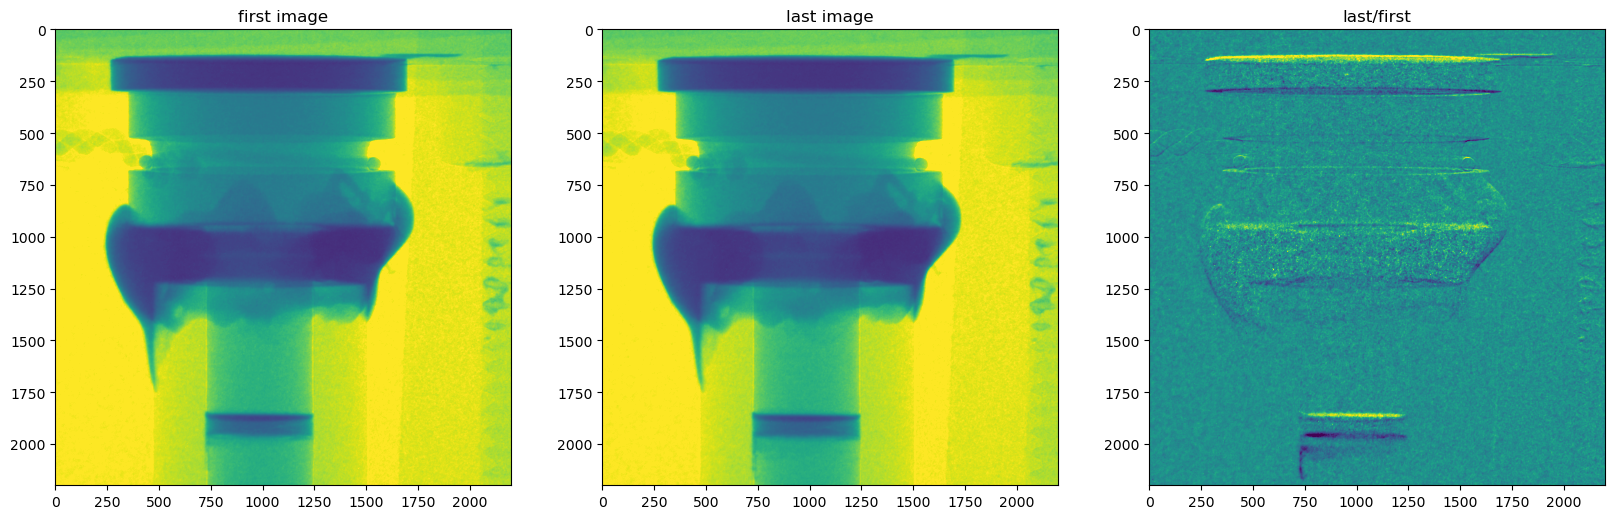

In [7]:
f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_stack[0], vmin=0, vmax=1)
ax[0].set_title('first image')

ax[1].imshow(img_stack[-1], vmin=0, vmax=1)
ax[1].set_title('last image')

ax[2].imshow(np.divide(img_stack[-1], img_stack[0]), vmin=0.8, vmax=1.2)
ax[2].set_title('last/first')

img_first_sobel = ski.filters.sobel(img_stack[0])
img_last_sobel = ski.filters.sobel(img_stack[-1])

f, ax = plt.subplots(1, 3, figsize=(20, 20))

ax[0].imshow(img_first_sobel, vmin=0, vmax=0.2)
ax[0].set_title('first image')

ax[1].imshow(img_last_sobel, vmin=0, vmax=0.2)
ax[1].set_title('last image')

ax[2].imshow(np.divide(img_last_sobel, img_first_sobel), vmin=0.8, vmax=1.2)
ax[2].set_title('last/first')

mov_idx = -1
# trans_algo = 'RIGID_BODY'
trans_algo = 'TRANSLATION'

ref = img_stack[0]
mov = img_stack[mov_idx]

# ref_edge = ski.filters.sobel(ref)
# mov_edge = ski.filters.sobel(mov)

sr = StackReg(trans_algo_dict[trans_algo])
reg_edge = sr.register_transform(ref_edge, mov_edge)
reg_edge = reg_edge.clip(min=0)
reg_by_edge = sr.transform(mov=mov)

f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(ref, vmin=0, vmax=1)
ax[0].set_title('first image')

ax[1].imshow(np.divide(mov, ref), vmin=0.8, vmax=1.2)
ax[1].set_title('diff of unreg images')

ax[2].imshow(np.divide(reg_by_edge, ref), vmin=0.8, vmax=1.2)
ax[2].set_title('diff of reg imags')

Text(0.5, 1.0, 'last/first')

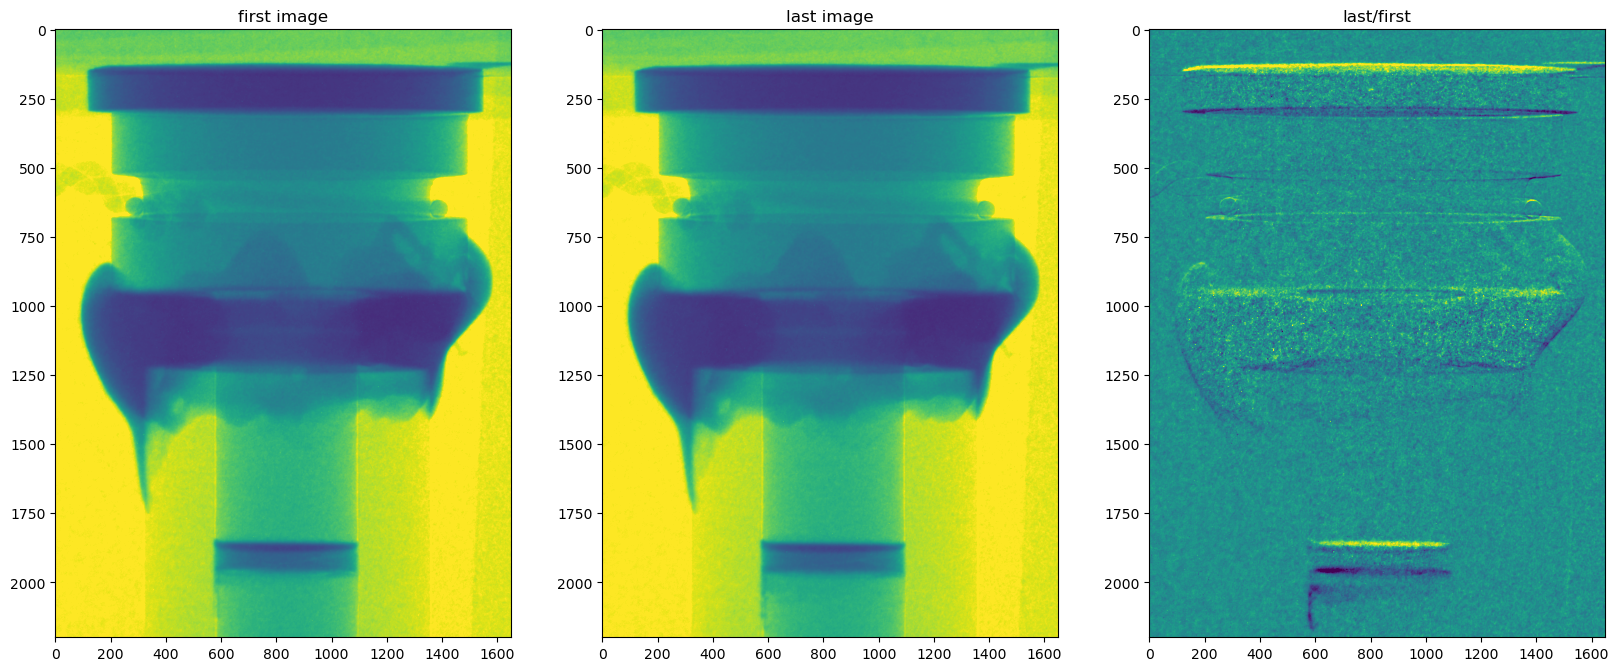

In [9]:
roi = True
# roi = False
roi_left = 150
roi_right = 1800
roi_top = 0
roi_bottom = 2300
# roi_left = 250
# roi_right = 1350
# roi_top = 900
# roi_bottom = 1350
#########################
#########################
img_stack_roi = rocku.crop(img_stack, roi_left, roi_right, roi_top, roi_bottom, roi)
f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_stack_roi[0], vmin=0, vmax=1)
ax[0].set_title('first image')

ax[1].imshow(img_stack_roi[-1], vmin=0, vmax=1)
ax[1].set_title('last image')

ax[2].imshow(np.divide(img_stack_roi[-1], img_stack_roi[0]), vmin=0.8, vmax=1.2)
ax[2].set_title('last/first')

In [10]:
trans_algo = 'RIGID_BODY'
# trans_algo = 'TRANSLATION'
reference = 'previous'
sr = StackReg(trans_algo_dict[trans_algo])
reg_stack_roi = sr.register_transform_stack(img_stack_roi, reference=reference, verbose=True)#, progress_callback=rocku.show_progress)
# reg_stack_roi_prev = sr.register_transform_stack(img_stack_roi, reference='previous', verbose=True)#, progress_callback=rocku.show_progress)
# reg_stack_roi_avg = sr.register_transform_stack(img_stack_roi, reference='mean', verbose=True)#, progress_callback=rocku.show_progress)
# reg_stack_roi_1st = sr.register_transform_stack(img_stack_roi, reference='first', n_frames=1, verbose=True)#, progress_callback=rocku.show_progress)
# reg_stack_roi_1st10 = sr.register_transform_stack(img_stack_roi, reference='first', n_frames=10, verbose=True)#, progress_callback=rocku.show_progress)
# reg_stack_roi_1st10mov = sr.register_transform_stack(img_stack_roi, reference='first', n_frames=10, moving_average=10, verbose=True)#, progress_callback=rocku.show_progress)

100%|█████████████████████████████████████████| 196/196 [06:33<00:00,  2.01s/it]


Text(0.5, 1.0, 'diff of registered')

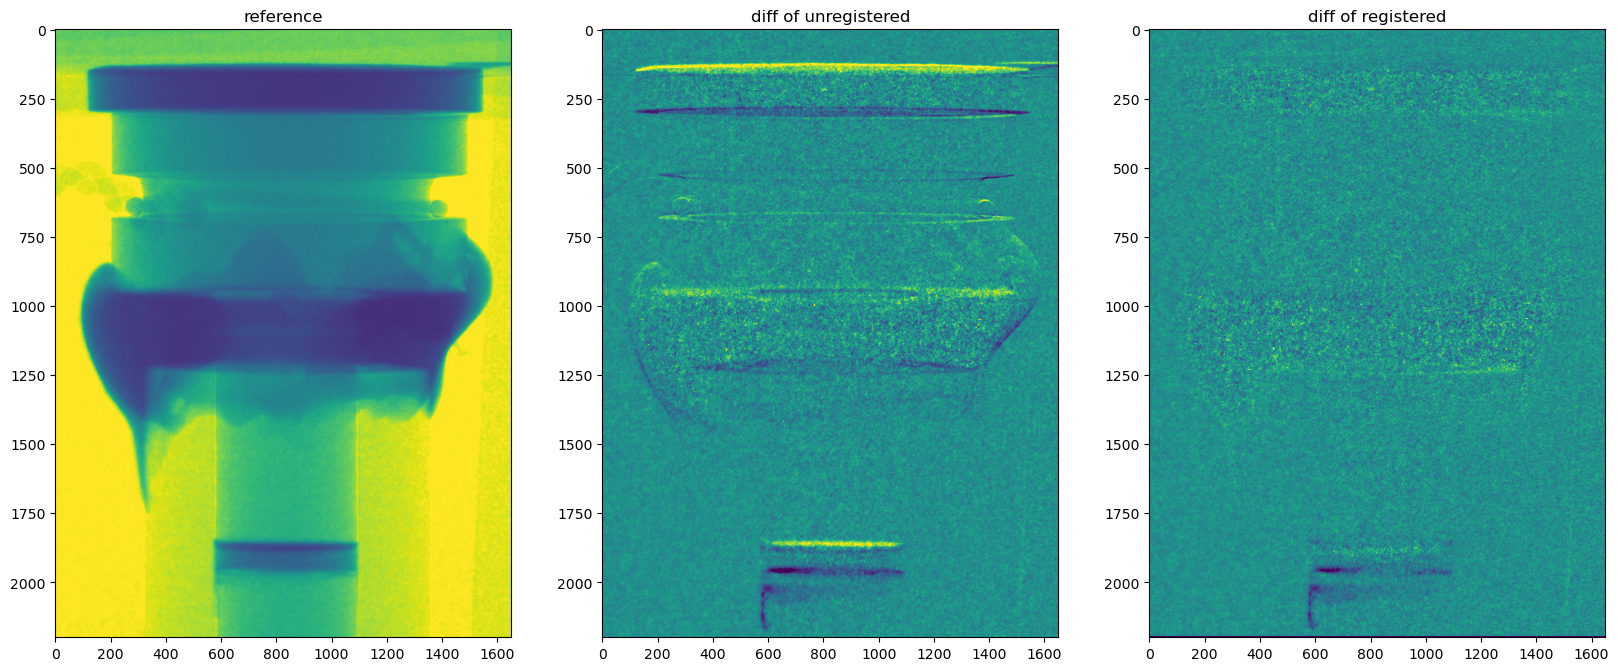

In [11]:
# print(ref_roi.shape)
ref_idx = 0
mov_idx = -1
reg_check = reg_stack_roi[:]
# if rescale_factor != 1:
#     ref_roi = ski.transform.rescale(ref_roi, rescale_factor)
#     mov_roi = ski.transform.rescale(mov_roi, rescale_factor)
#     print(ref_roi.shape)
f, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_stack_roi[ref_idx], vmin=0, vmax=1)
ax[0].set_title('reference')

ax[1].imshow(np.divide(img_stack_roi[mov_idx], img_stack_roi[ref_idx]), vmin=0.8, vmax=1.2)
ax[1].set_title('diff of unregistered')

ax[2].imshow(np.divide(reg_check[mov_idx], reg_check[ref_idx]), vmin=0.8, vmax=1.2)
ax[2].set_title('diff of registered')

In [12]:
reg_ratio = np.divide(reg_stack_roi, np.mean([reg_stack_roi[0], reg_stack_roi[1]], axis=0))

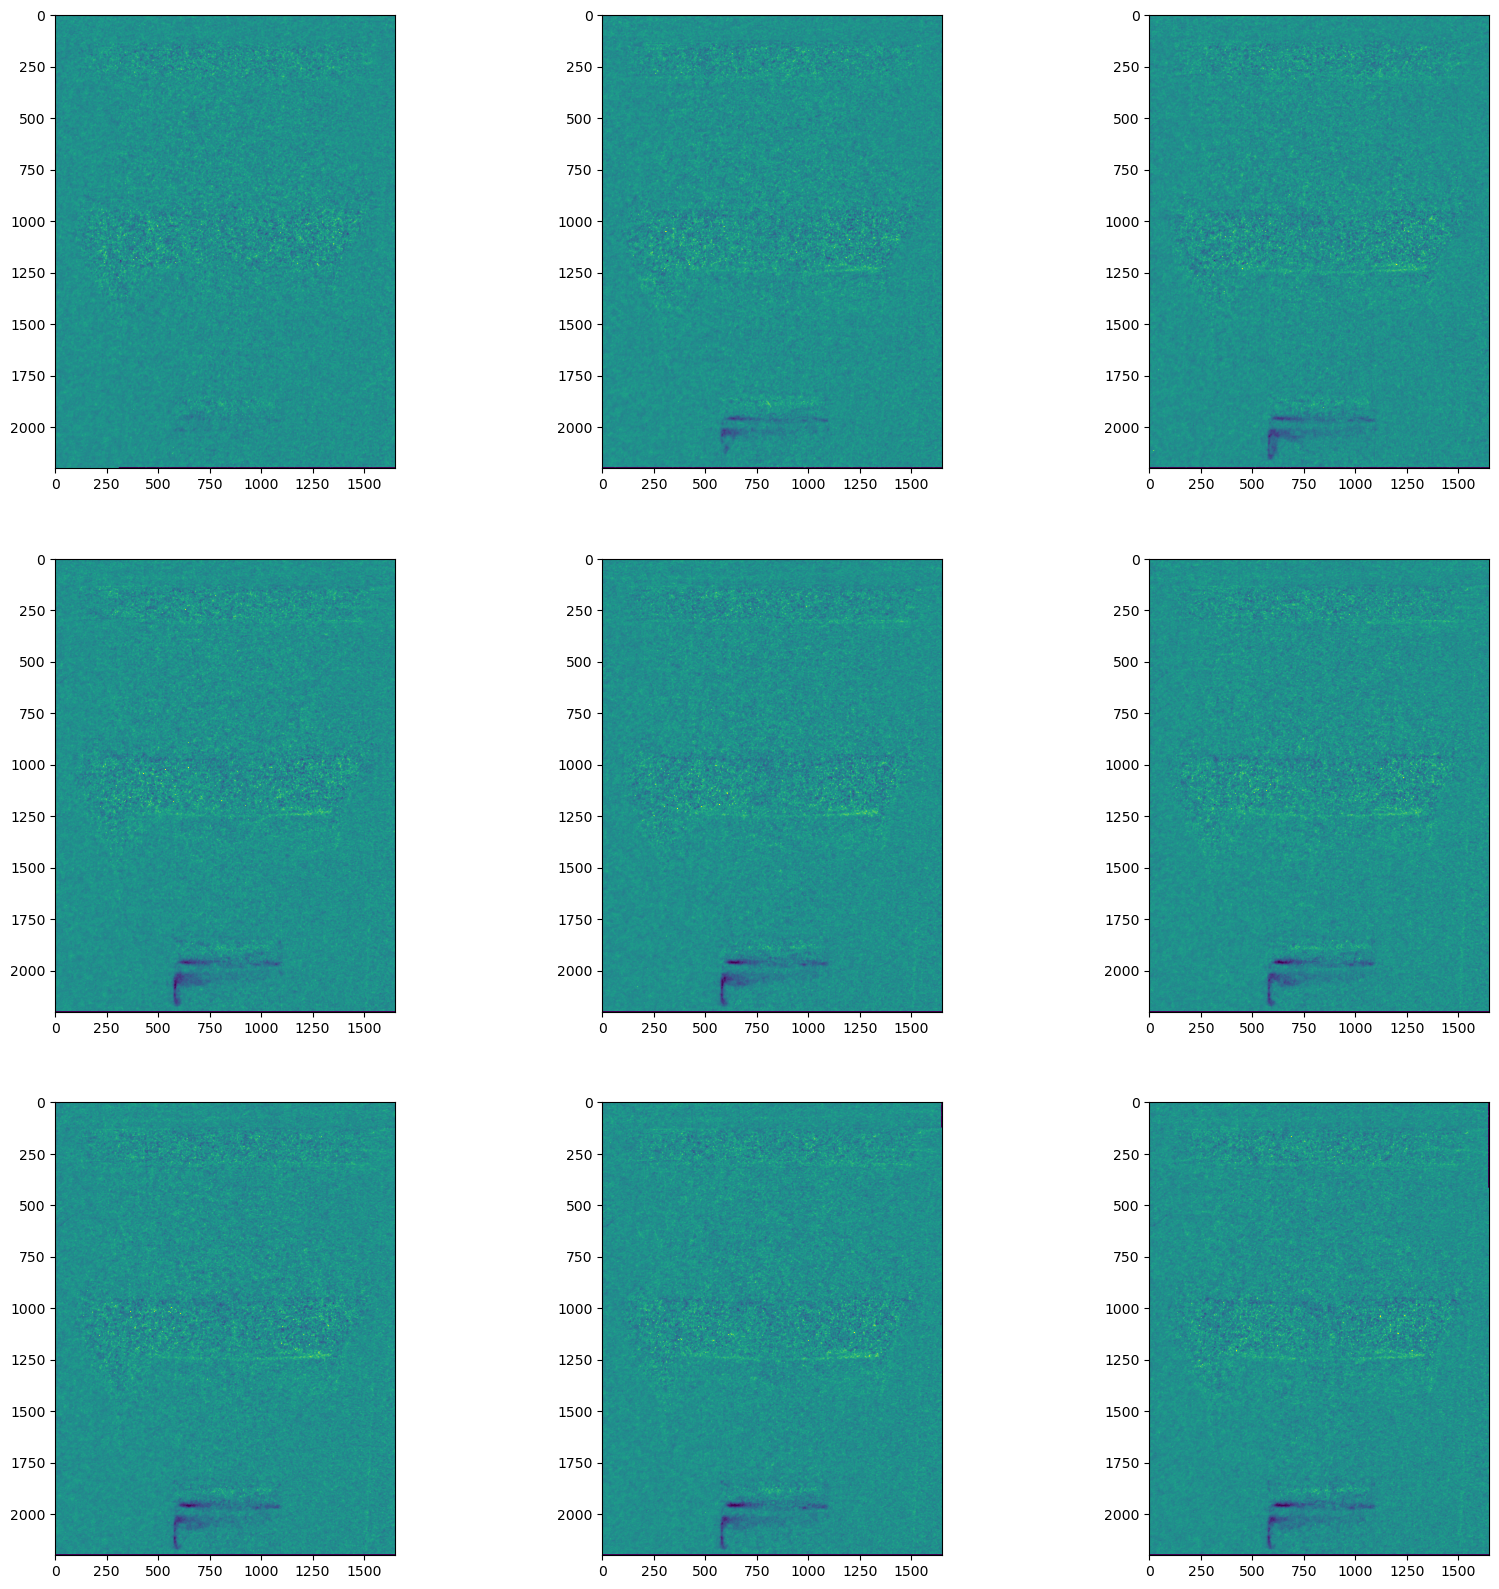

In [13]:
f, ax = plt.subplots(3, 3, figsize=(20, 20))

ax[0][0].imshow(reg_ratio[10], vmin=0.8, vmax=1.2)
ax[0][1].imshow(reg_ratio[30], vmin=0.8, vmax=1.2)
ax[0][2].imshow(reg_ratio[50], vmin=0.8, vmax=1.2)

ax[1][0].imshow(reg_ratio[80], vmin=0.8, vmax=1.2)
ax[1][1].imshow(reg_ratio[100], vmin=0.8, vmax=1.2)
ax[1][2].imshow(reg_ratio[120], vmin=0.8, vmax=1.2)

ax[2][0].imshow(reg_ratio[140], vmin=0.8, vmax=1.2)
ax[2][1].imshow(reg_ratio[160], vmin=0.8, vmax=1.2)
ax[2][2].imshow(reg_ratio[180], vmin=0.8, vmax=1.2)

# Crop

Cropped:


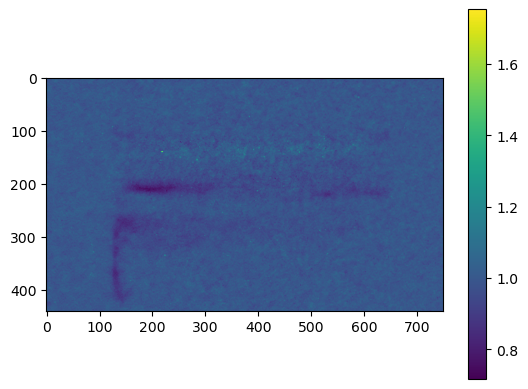

In [21]:
###################### need to change start
crop = True
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 450
crop_right = 1200
crop_top = 1750#530
crop_bottom = 2190
###################### need to change end
reg_ratio_out = rocku.crop(reg_ratio, crop_left, crop_right, crop_top, crop_bottom, crop)

print("Cropped:")
plt.imshow(reg_ratio_out[-1])
plt.colorbar()
plt.show()

# Save files

In [22]:
save_to = scan_dir + "_" + trans_algo# + "_roi"
save_to_norm = save_to + '/normalized'
save_to_ratio = save_to + '/ratio'

if crop:
    reg_stack_subdir = save_to_norm + "/full"
    reg_ratio_subdir = save_to_ratio + "/full"
    reg_stack_crop_subdir = save_to_norm + "/crop"
    reg_ratio_crop_subdir = save_to_ratio + "/crop"
else:
    reg_stack_subdir = save_to_norm
    reg_ratio_subdir = save_to_ratio

reg_stack_out = reg_stack_roi
reg_stack_crop_out = rocku.crop(reg_stack_roi, crop_left, crop_right, crop_top, crop_bottom, crop)
###############################
###############################
if not os.path.exists(save_to):
    os.mkdir(save_to)
if not os.path.exists(save_to_norm):
    os.mkdir(save_to_norm)
if not os.path.exists(save_to_ratio):
    os.mkdir(save_to_ratio)
if not os.path.exists(reg_stack_subdir):
    os.mkdir(reg_stack_subdir)
if not os.path.exists(reg_ratio_subdir):
    os.mkdir(reg_ratio_subdir)
print("Saving to '{}' ...".format(reg_stack_subdir))
print("Saving to '{}' ...".format(reg_ratio_subdir))
for i, e_name in tqdm(enumerate(fname_list)):
    img_pl = Image.fromarray(reg_stack_out[i])
    img_pl.save(reg_stack_subdir + "/" + e_name)
    img_pl_ratio = Image.fromarray(reg_ratio[i])
    img_pl_ratio.save(reg_ratio_subdir + "/" + e_name)
    if crop:
        if not os.path.exists(reg_stack_crop_subdir):
            os.mkdir(reg_stack_crop_subdir)
        if not os.path.exists(reg_ratio_crop_subdir):
            os.mkdir(reg_ratio_crop_subdir)
        img_pl_crop = Image.fromarray(reg_stack_crop_out[i])
        img_pl_crop.save(reg_stack_crop_subdir + "/" + e_name)
        img_pl_ratio_crop = Image.fromarray(reg_ratio_out[i])
        img_pl_ratio_crop.save(reg_ratio_crop_subdir + "/" + e_name)
    

Saving to '/HFIR/CG1D/IPTS-32328/shared/processed_data/normalized/binned/2024_03_09_batteries_2D_cycling_binned_by_3_sample9_RIGID_BODY/normalized/full' ...
Saving to '/HFIR/CG1D/IPTS-32328/shared/processed_data/normalized/binned/2024_03_09_batteries_2D_cycling_binned_by_3_sample9_RIGID_BODY/ratio/full' ...


197it [00:16, 12.22it/s]
